# TKT4108 Structural Dynamics 2

## Exercise 10

**Main topics:** Signal processing and system identification

**References:** Github examples, lecture notes


### Problem 1: System identification

<img src='shearframe_5dof.svg'>

In this problem, we will consider a share frame from a previous problem set. Use the code below to obtain acceleration time series:

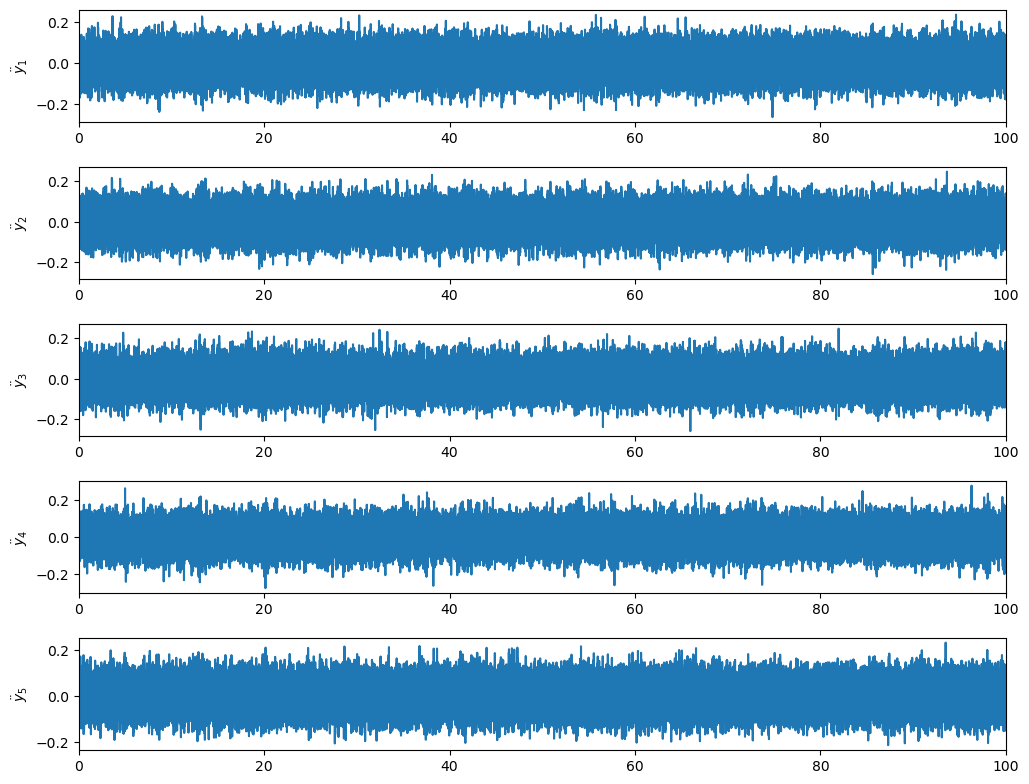

In [9]:
import numpy as np
from scipy import linalg as spla

import sys
sys.path.append('./../../modules')
from time_integration import * # Import all functions in the module time_integration

from matplotlib import pyplot as plt
from scipy import signal as spsi

M = np.eye(5) *1000
K = np.zeros((6,6))
EI = 2.1e11*3.34e-6
L = 3
ks = 2 *12*EI/L**3

for k in range(5):
    K[k+1,k+1] = K[k+1,k+1] + ks
    K[k,k] = K[k,k] + ks
    K[k+1,k] = K[k+1,k] -ks
    K[k,k+1] = K[k,k+1] -ks

K = K[1::,1::] # Introduce boundary conditions

lam, vec = spla.eig(K,M)

idx_sort = np.argsort(np.abs(lam))
lam = lam[idx_sort]
vec = vec[:,idx_sort]

f = np.real(lam**0.5)/2/np.pi

M_modal = vec.T @ M @ vec

C_modal = 2*np.eye(5)*0.02*M_modal*np.diag(f)*2*np.pi

C = vec @ C_modal @ vec.T

dt=0.001

t = np.arange(0,100,dt)

x=np.random.normal(0,50, size=(5,len(t))) # White noise loading

u0 = np.zeros((5,1))
udot0 = np.zeros((5,1))

_, _, y2dot = linear_newmark_krenk(M,C,K,x,u0,udot0,dt)

fix, axs = plt.subplots(5,1,figsize=(10,8))

plt.tight_layout()

for k in range(5):
    axs[k].plot(t,y2dot[k,:])
    axs[k].set_ylabel('$\ddot{y}_' + str(k+1) + '$')
    axs[k].set_xlim(0,100)

**a)** Solve the eigenvalue problem and obtain the undamped natural frequencies and modes shapes.

**b)** Use simulated time series to identify frequencies and modes using the basic frequency domain method (peak picking).

**c)** Use simulated time series to identify frequencies and modes using frequency domain decomposition (FDD).


### Problem 2: Hangarbrua

You will now look at measurement data collected from Hangarbrua during the field demo.

Download the text file *hangarbrua_data_processed.txt* and import the data in Python using the code below.

Use the frequency domain decomposition (FDD) to find the natural frequencies and mode shapes of the bridge. Plot the mode shapes and comment on the result.

The sensors are placed as shown in the figure and the coordinates are listed in the code below:

<img src='NodeID_transformed.png'  width="400">

The red coordinate system is used for this data (disregard the green and yellow).
<img src='All_reference_systems.jpg'  width="800">

Tips:

- Limit your search to modes below 10 or 15 Hz.

- Consider vertical acceleration measurements ($z$) first, and look at transvertical measurements ($y$) as a possible second step.

- You can expect to find 1-2 vertical modes and 1-2 transversal modes.

In [10]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal as spsi

acc_labels=np.loadtxt('hangarbrua_data_processed.txt',delimiter=',',skiprows=0, max_rows=1, dtype=str, usecols=range(1,61)) # Import labels

print('Acceleration labels: ')
print(acc_labels)

t=np.loadtxt('hangarbrua_data_processed.txt',delimiter=',',skiprows=1, usecols=[0]).T # Import time vector

acc=np.loadtxt('hangarbrua_data_processed.txt',delimiter=',',skiprows=1, usecols=range(1,61)).T # Import acceleration data

accm=np.mean(acc,axis=1)
acc=acc-np.atleast_2d(accm).T # Subtract the mean value

print('Length of time series in seconds:')
print(t[-1])

dt=t[2]-t[1]
fs=1/dt

print('Sample rate in Hz:')
print(fs)


Acceleration labels: 
['node1_x' 'node1_y' 'node1_z' 'node2_x' 'node2_y' 'node2_z' 'node3_x'
 'node3_y' 'node3_z' 'node4_x' 'node4_y' 'node4_z' 'node5_x' 'node5_y'
 'node5_z' 'node6_x' 'node6_y' 'node6_z' 'node7_x' 'node7_y' 'node7_z'
 'node8_x' 'node8_y' 'node8_z' 'node9_x' 'node9_y' 'node9_z' 'node10_x'
 'node10_y' 'node10_z' 'node11_x' 'node11_y' 'node11_z' 'node12_x'
 'node12_y' 'node12_z' 'node13_x' 'node13_y' 'node13_z' 'node14_x'
 'node14_y' 'node14_z' 'node15_x' 'node15_y' 'node15_z' 'node16_x'
 'node16_y' 'node16_z' 'node17_x' 'node17_y' 'node17_z' 'node18_x'
 'node18_y' 'node18_z' 'node19_x' 'node19_y' 'node19_z' 'node20_x'
 'node20_y' 'node20_z']
Length of time series in seconds:
693.125
Sample rate in Hz:
64.00098305509972


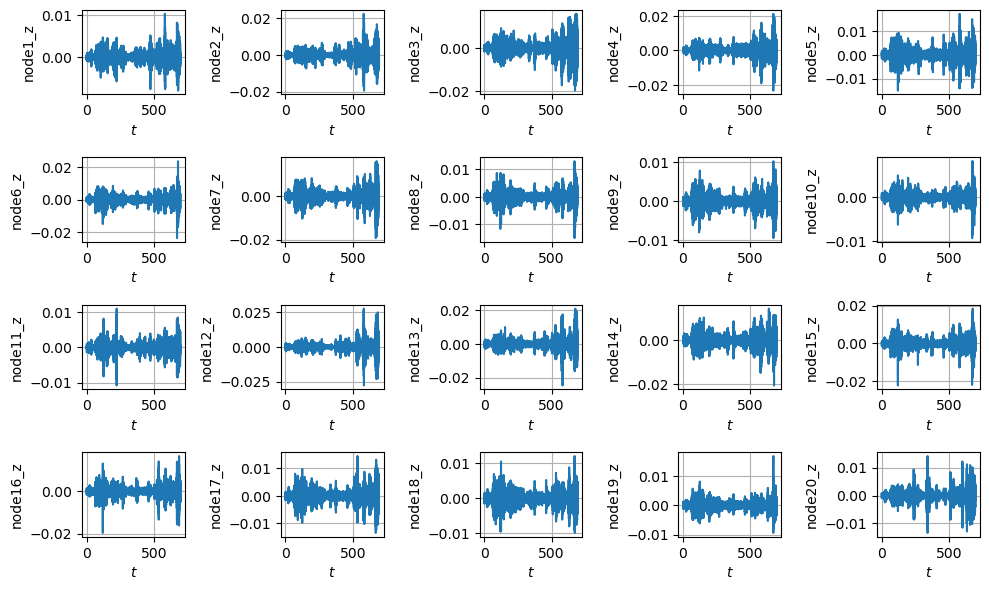

In [11]:
# Coordinate of sensors in [mm]
sensor_x=np.array([0,5785,11455,17298,20455,23835,27604,32004,37384,44584,0,5788,11458,17301,20445,23835,27604,32004,37384,44584,])
sensor_y=np.array([-4261,-4261,-4261,-4261,-4261,-4261,-4261,-4261,-4261,-4261,4261,4261,4261,4261,4261,4261,4261,4261,4261,4261])

index_x=range(0,60,3) # Index of all x-data (axial)
index_y=range(1,60,3) # Index of all y-data (transversal)
index_z=range(2,60,3) # Index of all z-data (vertical)

acc_z=acc[index_z,:] # Only vertical data
acc_labels_z=acc_labels[index_z]

# Plot all 20 vertical accelerations
idx=-1
fig, axs = plt.subplots(4,5,figsize=(10,6))    
for k1 in range(4):
    for k2 in range(5):
        ax = axs[k1,k2]

        idx=idx+1
        ax.plot(t,acc_z[idx])
        
        ax.set_ylabel(acc_labels_z[idx])
        ax.set_xlabel('$t$')
        ax.grid(True)
        
plt.tight_layout()
